In [1]:
!pip install torchmetrics
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-8iihb78x
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-8iihb78x
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit 4d20629756005085ca0f1f21605c796298ca0c16
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
from google.colab import drive
import os
from PIL import Image
import tifffile
import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt

In [71]:
# torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader , Dataset,random_split
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.functional import jaccard_index
import torch.optim as optim
from torchmetrics.classification import Accuracy

In [4]:
with zipfile.ZipFile("/content/data.zip", "r") as zip_ref:
    zip_ref.extractall()

In [5]:
class SegmentationDataset(Dataset):
  def __init__(self, image_paths, mask_paths, transform,target_transform):
    self.image_folder = image_paths
    self.mask_folder = mask_paths
    self.transform = transform
    self.target_transform = target_transform
    self.images = sorted(os.listdir(self.image_folder))
    self.masks = sorted(os.listdir(self.mask_folder))
  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    image_path = os.path.join(self.image_folder, self.images[idx])
    mask_path = os.path.join(self.mask_folder,self.images[idx].replace(".tif",".png"))

    image= tifffile.imread(image_path)
    mask=Image.open(mask_path)

    band_1 = image[..., 11]
    band_2 = image[..., 10]
    band_3 = image[..., 7]
    band_4 = image[..., 6]
    band_5 = image[..., 5]

    channels = [band_1, band_2, band_3, band_4, band_5]
    image_out = np.stack(channels, axis=-1)

    # apply transforms
    if self.transform:
        image_out = self.transform(image_out).float()

    mask = np.array(mask, dtype=np.float32)
    if self.target_transform:
        mask = self.target_transform(mask)

    return image_out, mask

In [6]:
images_path="/content/data/images"
mask_path="/content/data/labels"

In [7]:
transfer = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)
mask_transfer=transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

In [8]:
SegmentationDataset=SegmentationDataset(images_path,mask_path,transfer,mask_transfer)

In [9]:
img,mask=SegmentationDataset[0]

In [10]:
print(img.shape,type(img))
print(mask.shape,type(mask))

torch.Size([5, 128, 128]) <class 'torch.Tensor'>
torch.Size([1, 128, 128]) <class 'torch.Tensor'>


In [11]:
print(f"dataset number of sample = {len(SegmentationDataset)}")

dataset number of sample = 306


### Split data

In [12]:
train_size = int(0.8 * len(SegmentationDataset))
val_size=int(0.1 * len(SegmentationDataset))
test_size  = len(SegmentationDataset) - train_size - val_size

train_dataset,val_dataset,test_dataset = random_split(SegmentationDataset, [train_size,val_size,test_size])


In [13]:
print(f"size of train dataset is {len(train_dataset)}")
print(f"size of val dataset is {len(val_dataset)}")
print(f"size of test dataset is {len(test_dataset)}")

size of train dataset is 244
size of val dataset is 30
size of test dataset is 32


In [14]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [15]:
batch = next(iter(train_loader))
images, masks = batch

print("Images type:", type(images))
print("Images shape:", images.shape)
print("Images dtype:", images.dtype)

print("Masks type:", type(masks))
print("Masks shape:", masks.shape)
print("Masks dtype:", masks.dtype)


Images type: <class 'torch.Tensor'>
Images shape: torch.Size([8, 5, 128, 128])
Images dtype: torch.float32
Masks type: <class 'torch.Tensor'>
Masks shape: torch.Size([8, 1, 128, 128])
Masks dtype: torch.float32


### Prepare Our Model Functions

In [72]:
def train(num_epochs,model,namemodel,lr):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    acc = Accuracy(task="BINARY", num_classes=1).to(device)
    model.to(device)

    history = {
        "train_loss": [], "val_loss": [],
        "train_iou": [], "val_iou": [],
        "train_acc": [], "val_acc": []
    }

    best_val_loss = float("inf")
    best_model_path = f"{namemodel}_best_model.pth"

    for epoch in range(num_epochs):
        # ------------------ TRAIN ------------------
        model.train()
        train_total_loss = 0
        train_ious = []
        acc.reset()


        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_total_loss += loss.item()

            preds = torch.sigmoid(outputs)
            train_iou = jaccard_index(outputs, targets, task="binary")
            train_ious.append(train_iou.item())
            acc.update(outputs, targets)

        avg_train_loss = + train_total_loss / len(train_loader)
        avg_train_iou = sum(train_ious) / len(train_ious)
        train_acc=acc.compute().item()
        # ------------------ VALIDATION ------------------
        model.eval()
        val_total_loss = 0
        val_ious = []
        acc_val = Accuracy(task="BINARY", num_classes=1).to(device)


        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_total_loss += loss.item()

                val_iou = jaccard_index(outputs, targets.int(), task="binary")
                val_ious.append(val_iou.item())
                acc_val.update(outputs, targets.int())

        avg_val_loss = val_total_loss / len(val_loader)
        avg_val_iou = sum(val_ious) / len(val_ious)
        val_acc=acc_val.compute().item()

        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["train_iou"].append(avg_train_iou)
        history["val_iou"].append(avg_val_iou)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"Saved Best Model at Epoch {epoch+1}")

        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"  Train Loss: {avg_train_loss:.4f} | IoU: {avg_train_iou:.4f} | Acc: {train_acc:.4f}")
        print(f"  Val   Loss: {avg_val_loss:.4f} | IoU: {avg_val_iou:.4f} | Acc: {val_acc:.4f}")
        print("="*50)

    return history,model


In [73]:
def visualize_metrics(history):
  plt.plot(history["train_loss"], label="Train Loss")
  plt.plot(history["val_loss"], label="Val Loss")
  plt.legend()
  plt.title("Loss")
  plt.show()

  plt.plot(history["train_iou"], label="Train IoU")
  plt.plot(history["val_iou"], label="Val IoU")
  plt.legend()
  plt.title("IoU")
  plt.show()

  plt.plot(history["train_acc"], label="Train Acc")
  plt.plot(history["val_acc"], label="Val Acc")
  plt.legend()
  plt.title("Accuracy")
  plt.show()

In [74]:
def evaluate_on_test(model, test_loader=test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    criterion = nn.BCELoss()
    acc = Accuracy(task="binary", num_classes=1).to(device)

    total_loss = 0
    total_iou = 0
    num_batches = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()


            acc.update(outputs, targets.int())
            batch_iou = jaccard_index(outputs, targets.int(), task="binary", num_classes=1)
            total_iou += batch_iou.item()
            num_batches += 1

    avg_loss = total_loss / len(test_loader)
    test_acc = acc.compute().item()
    test_iou = total_iou / num_batches

    print(f"Test Loss: {avg_loss:.4f} | Acc: {test_acc:.4f} | IoU: {test_iou:.4f}")

    return avg_loss, test_acc, test_iou


In [75]:
def visualize_predictions(model, test_loader=test_loader):
  num_images = 3
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.eval()

  masks, preds = [], []

  with torch.no_grad():
      for inputs, targets in test_loader:
          inputs, targets = inputs.to(device), targets.to(device)
          outputs = model(inputs)

          for i in range(inputs.size(0)):
              if len(masks) < num_images:
                  masks.append(targets[i].detach().cpu())
                  preds.append(outputs[i].detach().cpu())

          if len(masks) >= num_images:
              break

  fig, axes = plt.subplots(num_images, 2, figsize=(6, 3 * num_images))

  for i in range(num_images):
      gt = masks[i]
      pred = preds[i]

      axes[i, 0].imshow(gt.squeeze(), cmap="gray")
      axes[i, 0].set_title("Ground Truth")
      axes[i, 0].axis("off")

      axes[i, 1].imshow(pred.squeeze(), cmap="gray")
      axes[i, 1].set_title("Predicted Mask")
      axes[i, 1].axis("off")

  plt.tight_layout()
  plt.show()


First Model Train , validation and testing

In [46]:
history,model=train(70,smp.Unet('resnet50', classes=1, activation='sigmoid',decoder_use_batchnorm=True,in_channels= 5),"unet_resnet",0.0001)

Saved Best Model at Epoch 1
Epoch [1/70]
  Train Loss: 0.5074 | IoU: 0.3977 | Acc: 0.7716
  Val   Loss: 0.5492 | IoU: 0.5446 | Acc: 0.7975
Saved Best Model at Epoch 2
Epoch [2/70]
  Train Loss: 0.3445 | IoU: 0.6149 | Acc: 0.8801
  Val   Loss: 0.2914 | IoU: 0.7188 | Acc: 0.9045
Saved Best Model at Epoch 3
Epoch [3/70]
  Train Loss: 0.3007 | IoU: 0.6475 | Acc: 0.8930
  Val   Loss: 0.2577 | IoU: 0.7540 | Acc: 0.9201
Saved Best Model at Epoch 4
Epoch [4/70]
  Train Loss: 0.2631 | IoU: 0.6957 | Acc: 0.9097
  Val   Loss: 0.2428 | IoU: 0.7394 | Acc: 0.9196
Saved Best Model at Epoch 5
Epoch [5/70]
  Train Loss: 0.2669 | IoU: 0.6752 | Acc: 0.9068
  Val   Loss: 0.2138 | IoU: 0.7918 | Acc: 0.9341
Saved Best Model at Epoch 6
Epoch [6/70]
  Train Loss: 0.2315 | IoU: 0.7207 | Acc: 0.9184
  Val   Loss: 0.2075 | IoU: 0.7777 | Acc: 0.9309
Saved Best Model at Epoch 7
Epoch [7/70]
  Train Loss: 0.2185 | IoU: 0.7358 | Acc: 0.9237
  Val   Loss: 0.2071 | IoU: 0.7726 | Acc: 0.9304
Saved Best Model at Epoch 8

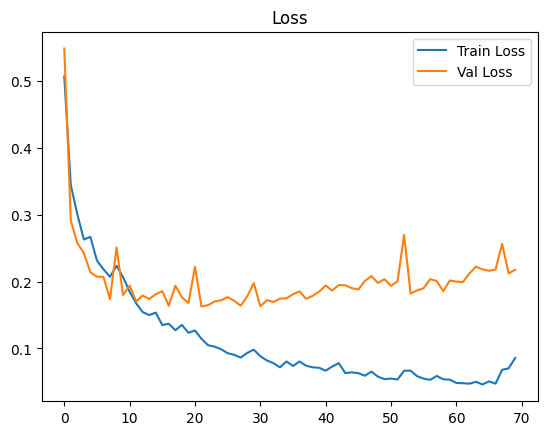

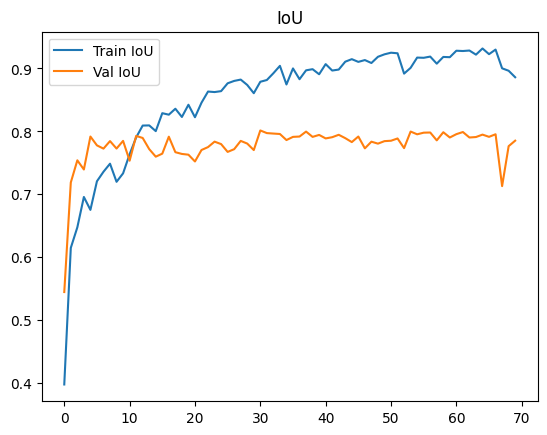

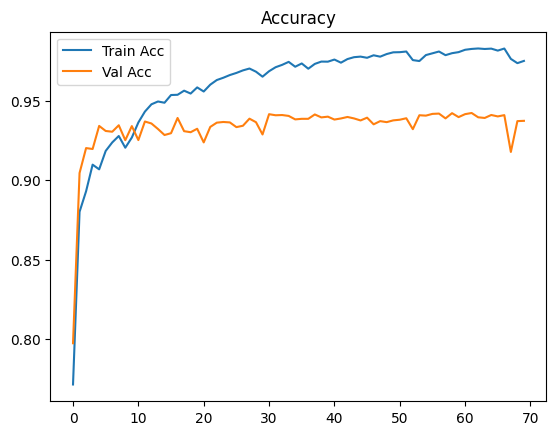

In [47]:
visualize_metrics(history)

In [48]:
unet_resnet50_loss, unet_resnet50_acc, unet_resnet50_iou=evaluate_on_test(model,test_loader)

Test Loss: 0.1901 | Acc: 0.9468 | IoU: 0.7711


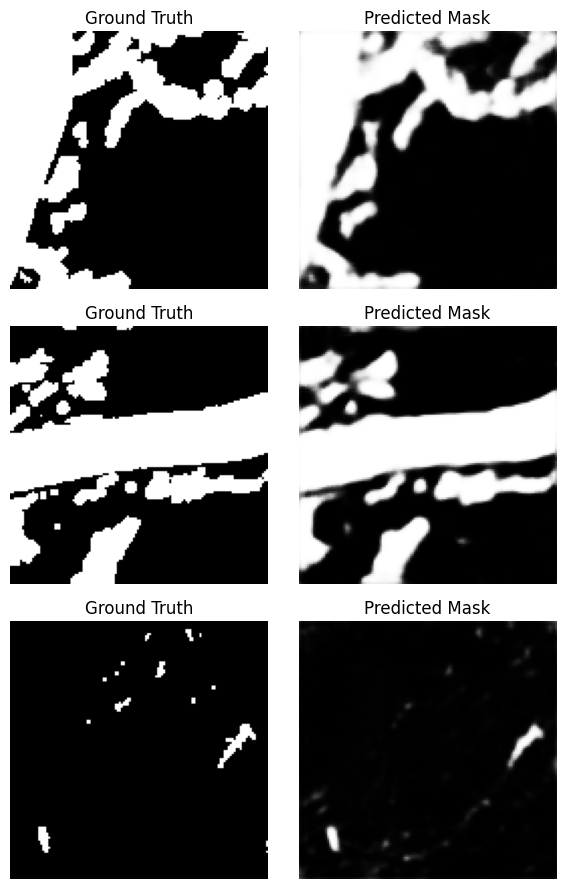

In [49]:
visualize_predictions(model,test_loader)

second model



In [25]:
history,model=train(60,smp.FPN('resnet50', classes=1, activation='sigmoid',decoder_use_batchnorm=True,in_channels= 5),"FPN_resnet34")

Saved Best Model at Epoch 1
Epoch [1/60]
  Train Loss: 0.5800 | IoU: 0.3898 | Acc: 0.7829
  Val   Loss: 0.2625 | IoU: 0.6540 | Acc: 0.8917
Saved Best Model at Epoch 2
Epoch [2/60]
  Train Loss: 0.3860 | IoU: 0.5440 | Acc: 0.8500
  Val   Loss: 0.2309 | IoU: 0.6799 | Acc: 0.9064
Saved Best Model at Epoch 3
Epoch [3/60]
  Train Loss: 0.3059 | IoU: 0.6171 | Acc: 0.8831
  Val   Loss: 0.2197 | IoU: 0.7170 | Acc: 0.9150
Saved Best Model at Epoch 4
Epoch [4/60]
  Train Loss: 0.2808 | IoU: 0.6422 | Acc: 0.8938
  Val   Loss: 0.2149 | IoU: 0.7258 | Acc: 0.9138
Saved Best Model at Epoch 5
Epoch [5/60]
  Train Loss: 0.2682 | IoU: 0.6519 | Acc: 0.8930
  Val   Loss: 0.1848 | IoU: 0.7469 | Acc: 0.9245
Saved Best Model at Epoch 6
Epoch [6/60]
  Train Loss: 0.2256 | IoU: 0.6873 | Acc: 0.9098
  Val   Loss: 0.1813 | IoU: 0.7716 | Acc: 0.9305
Saved Best Model at Epoch 7
Epoch [7/60]
  Train Loss: 0.2181 | IoU: 0.6974 | Acc: 0.9106
  Val   Loss: 0.1770 | IoU: 0.7796 | Acc: 0.9318
Epoch [8/60]
  Train Loss: 

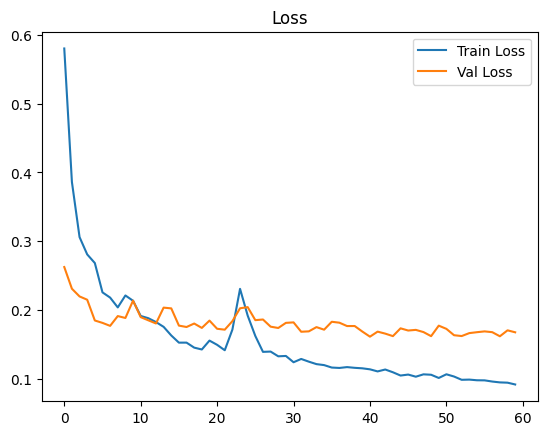

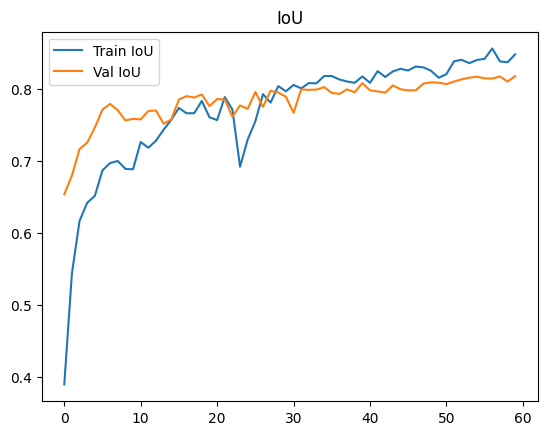

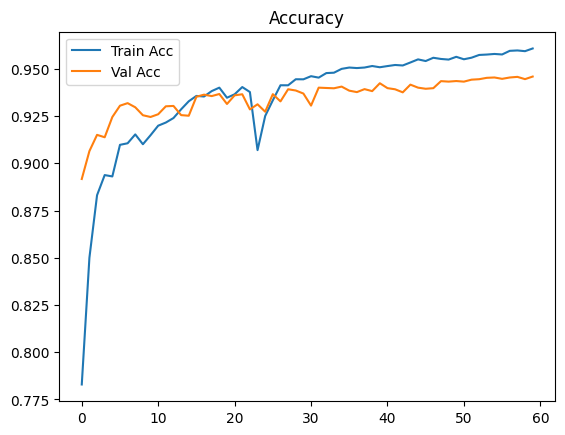

In [26]:
visualize_metrics(history)

In [27]:
FPN_resnet34_loss, FPN_resnet34_acc, FPN_resnet34_iou=evaluate_on_test(model,test_loader)

Test Loss: 0.1960 | Acc: 0.9400 | IoU: 0.7400


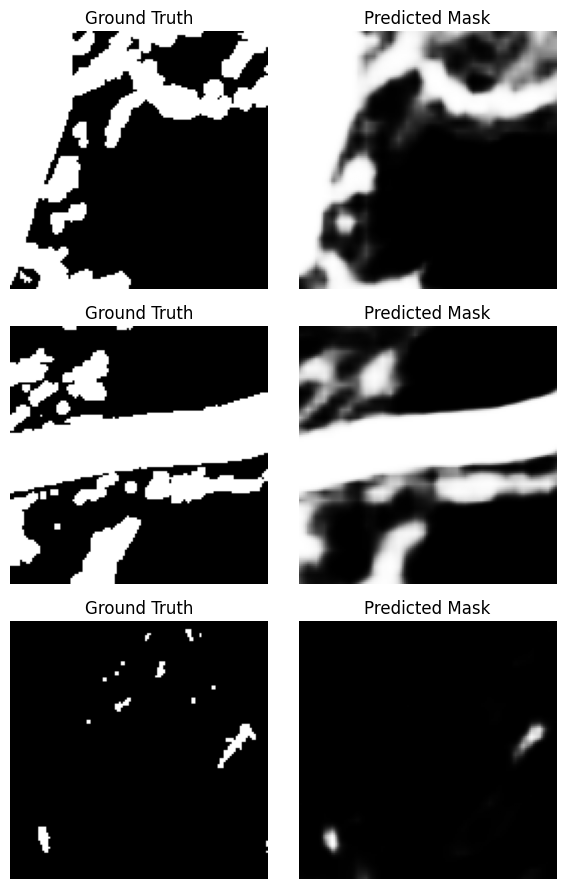

In [28]:
visualize_predictions(model,test_loader)

third model



In [80]:
history,model=train(100,smp.PSPNet('resnet50', classes=1, activation='sigmoid',decoder_use_batchnorm=True,in_channels= 5),"PSPNet_resnet50",0.00001)

Saved Best Model at Epoch 1
Epoch [1/100]
  Train Loss: 0.8364 | IoU: 0.3078 | Acc: 0.4712
  Val   Loss: 0.8357 | IoU: 0.2617 | Acc: 0.3109
Saved Best Model at Epoch 2
Epoch [2/100]
  Train Loss: 0.5852 | IoU: 0.4088 | Acc: 0.6980
  Val   Loss: 0.5507 | IoU: 0.4715 | Acc: 0.7440
Saved Best Model at Epoch 3
Epoch [3/100]
  Train Loss: 0.4617 | IoU: 0.4985 | Acc: 0.7941
  Val   Loss: 0.4392 | IoU: 0.5873 | Acc: 0.8392
Saved Best Model at Epoch 4
Epoch [4/100]
  Train Loss: 0.4074 | IoU: 0.5317 | Acc: 0.8326
  Val   Loss: 0.3542 | IoU: 0.6537 | Acc: 0.8807
Saved Best Model at Epoch 5
Epoch [5/100]
  Train Loss: 0.3614 | IoU: 0.5584 | Acc: 0.8577
  Val   Loss: 0.3332 | IoU: 0.6666 | Acc: 0.8862
Saved Best Model at Epoch 6
Epoch [6/100]
  Train Loss: 0.3669 | IoU: 0.5365 | Acc: 0.8518
  Val   Loss: 0.3200 | IoU: 0.6721 | Acc: 0.8886
Saved Best Model at Epoch 7
Epoch [7/100]
  Train Loss: 0.3436 | IoU: 0.5547 | Acc: 0.8609
  Val   Loss: 0.2575 | IoU: 0.7180 | Acc: 0.9089
Saved Best Model at 

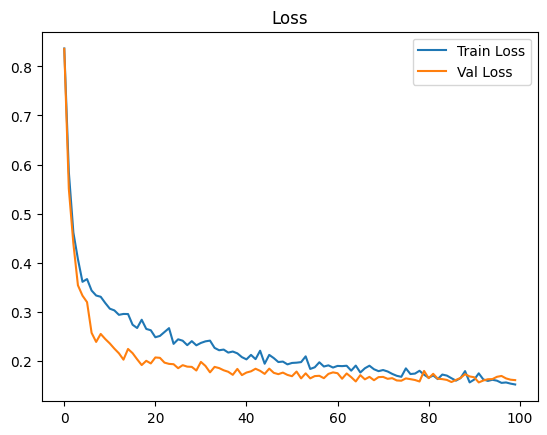

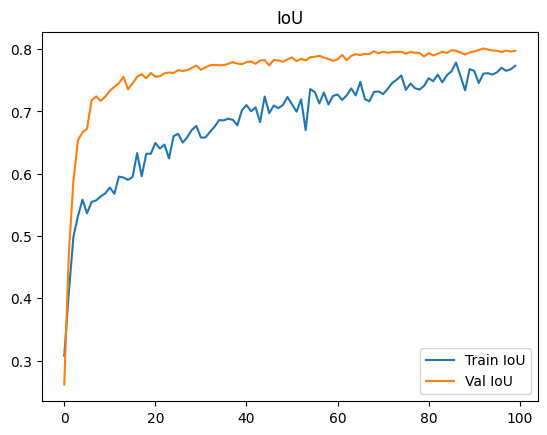

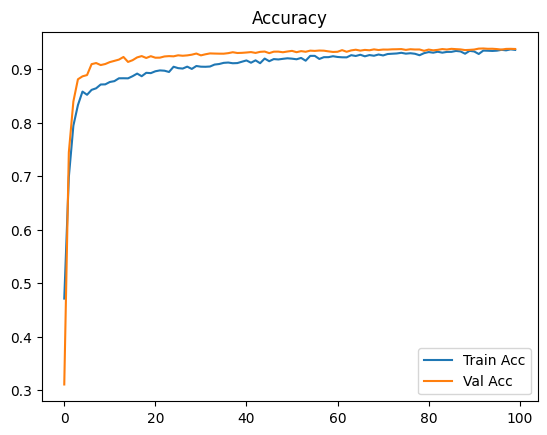

In [81]:
visualize_metrics(history)

In [84]:
PSPNet_resnet50_loss,PSPNet_resnet50_acc, PSPNet_resnet50_iou=evaluate_on_test(model,test_loader)

Test Loss: 0.2034 | Acc: 0.9236 | IoU: 0.6690


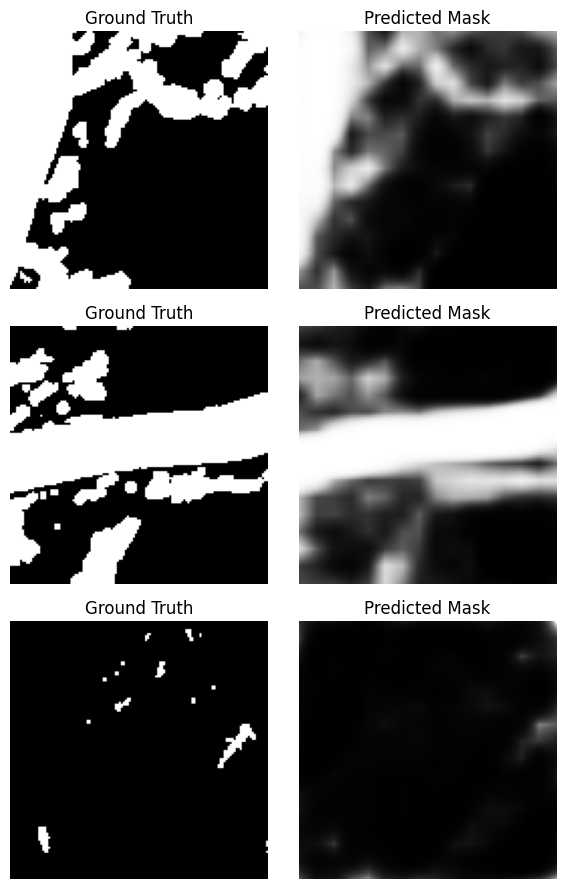

In [83]:
visualize_predictions(model,test_loader)

### Models Summary

In [85]:
data = {
    "Accuracy": [round(unet_resnet50_acc, 3), round(FPN_resnet34_acc, 3), round(PSPNet_resnet50_acc, 3)],
    "Loss": [round(unet_resnet50_loss, 3), round(FPN_resnet34_loss, 3), round(PSPNet_resnet50_loss, 3)],
    "IoU": [round(unet_resnet50_iou, 3), round(FPN_resnet34_iou, 3), round(PSPNet_resnet50_iou, 3)]
}

pd.DataFrame(data,index=["Unet resnet 50", "FPN Resnet34", "PSPNet Resnet101"])

,Accuracy,Loss,IoU
Unet resnet 50,0.947,0.190,0.771
FPN Resnet34,0.940,0.196,0.740
PSPNet Resnet101,0.924,0.203,0.669
